In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from results_data import all_results, results

In [20]:
ielts_data = pd.read_excel('ielts_scores.xlsx', index_col=0)

In [21]:
#results data 
all_results = all_results
results = results

#print(len(all_results))

In [22]:
#calculate total scores for skills
all_results["listening_total"] = all_results["EX1 Listening"]
all_results["reading_total"] = ((all_results["EX3 Reading"] * 0.6) + (all_results["CW1"] * 0.4))
all_results["writing_total"] = ((all_results["EX3 Writing"] * 0.6) + (all_results["CW3"] * 0.4))
all_results["speaking_total"] = ((all_results["EX2 Speaking"] * 0.5) + (all_results["CW2"] * 0.5))
all_results["overall_total"] = ((all_results["listening_total"] + all_results["reading_total"] + all_results["writing_total"] + all_results["speaking_total"])/4)

#totals df
totals = all_results[["Full Name", "cohort", "programme", "listening_total", "reading_total", "writing_total", "speaking_total", "overall_total"]]

In [23]:
#convert scores to ielts equivalents
def ielts_convertor(row):
  if row >= 90:
    val = 8.0
  elif row >= 80:
    val = 7.5
  elif row >= 70:
    val = 7.0
  elif row >= 60:
    val = 6.5
  elif row >= 50:
    val = 6.0
  elif row >= 40:
    val = 5.5
  elif row >= 30:
    val = 5.0
  elif row >= 20:
    val = 4.5
  else:
    val = 4.0
  return val

totals["listening_total"] = totals["listening_total"].apply(ielts_convertor)
totals["reading_total"] = totals["reading_total"].apply(ielts_convertor)
totals["writing_total"] = totals["writing_total"].apply(ielts_convertor)
totals["speaking_total"] = totals["speaking_total"].apply(ielts_convertor)
totals["overall_total"] = totals["overall_total"].apply(ielts_convertor)



<ipython-input-23-cc19c6cd2910>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totals["listening_total"] = totals["listening_total"].apply(ielts_convertor)
<ipython-input-23-cc19c6cd2910>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totals["reading_total"] = totals["reading_total"].apply(ielts_convertor)
<ipython-input-23-cc19c6cd2910>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [24]:
#remove non-ielts scores
ielts_data = ielts_data[~(ielts_data.overall_ielts > 9.0)]


In [25]:
#combine with IELTS data
all_data = totals.join(ielts_data, how="left")

all_data.dropna(how="any", inplace=True)



In [26]:
#calculate percentage change from ielts score
def pct_change(colA, colB):
  return round(((colA - colB) / colB) * 100, 1)

all_data["listening_change"] = pct_change(all_data["listening_total"], all_data["listening_ielts"])

all_data["reading_change"] = pct_change(all_data["reading_total"], all_data["reading_ielts"])

all_data["writing_change"] = pct_change(all_data["writing_total"], all_data["writing_ielts"])

all_data["speaking_change"] = pct_change(all_data["speaking_total"], all_data["speaking_ielts"])

all_data["overall_change"] = pct_change(all_data["overall_total"], all_data["overall_ielts"])

#print(all_data)

In [27]:
#reset index
all_data["student_id"] = all_data.index
all_data = all_data.reset_index(drop=True)

In [28]:
#add col to say if improved or not
def better_or_worse(row):
  if row > 0:
    val = "improvement"
  elif row == 0:
    val = "same"
  else:
    val = "regression"
  return val

all_data["listening_status"] = all_data.listening_change.apply(better_or_worse)
all_data["reading_status"] = all_data.reading_change.apply(better_or_worse)
all_data["writing_status"] = all_data.writing_change.apply(better_or_worse)
all_data["speaking_status"] = all_data.speaking_change.apply(better_or_worse)
all_data["overall_status"] = all_data.overall_change.apply(better_or_worse)
  

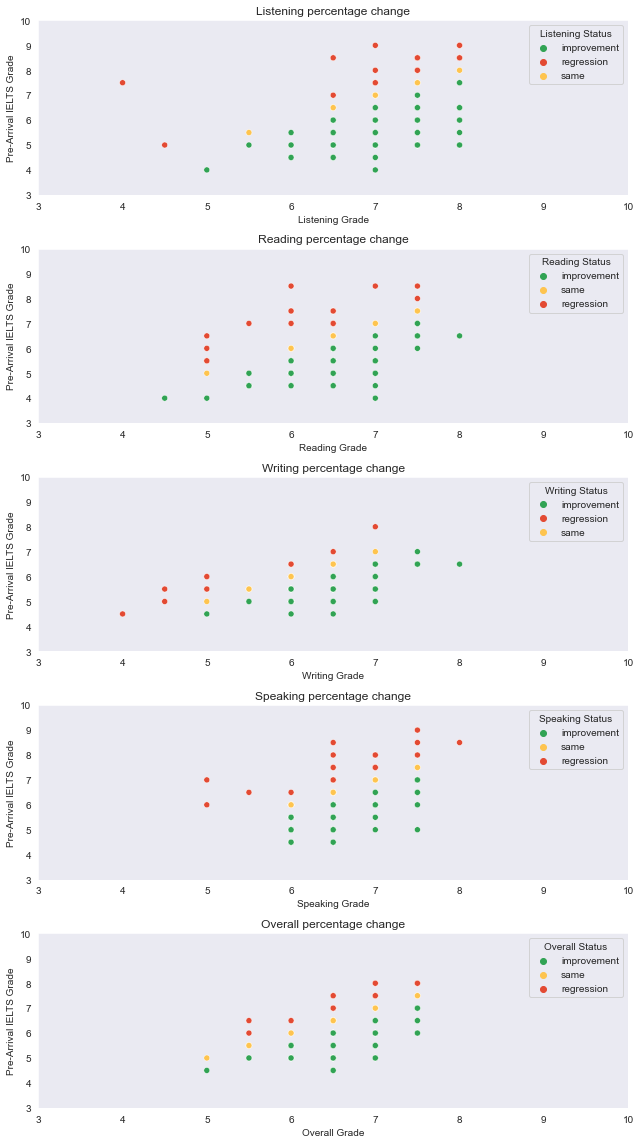

In [29]:
#sort improvers and regressors

fig, axs = plt.subplots(5, figsize=(9,16), sharey=True)
palette ={"improvement": "#31a354", "same": "#fec44f", "regression": "#e34a33"}
sns.set_style("dark")


def plot_scatter(skills):
  i = 0
  for skill in skills:
    sns.scatterplot(x="{}_total".format(skill), y = "{}_ielts".format(skill), hue="{}_status".format(skill), data=all_data, ax=axs[i], palette=palette)
    axs[i].set_xlabel("{} Grade".format(skill.capitalize()))
    axs[i].set_ylabel("Pre-Arrival IELTS Grade")
    axs[i].set_xlim(3.0, 10.0)
    axs[i].set_ylim(3.0, 10.0)
    axs[i].set_title("{} percentage change".format(skill.capitalize()))
    axs[i].legend(title="{} Status".format(skill.capitalize()))
    i += 1

plot_scatter(["listening", "reading", "writing", "speaking", "overall"])
plt.subplots_adjust()
plt.tight_layout()
plt.show()


In [30]:
#status df
data = {"Listening Status": all_data.listening_status.value_counts(), "Reading Status": all_data.reading_status.value_counts(), "Writing Status": all_data.writing_status.value_counts(), "Speaking Status": all_data.speaking_status.value_counts(), "Overall Status": all_data.overall_status.value_counts()}
status_df = pd.DataFrame(data)

#student statuses
student_status_df = all_data[["student_id", "Full Name", "cohort", "programme", "listening_change", "listening_status", "reading_change", "reading_status", "writing_change", "writing_status", "speaking_change", "speaking_status", "overall_change", "overall_status"]]

student_status_df.set_index("student_id", drop=True, inplace=True)

student_status_df.rename({"listening_change": "% Listening Change", "reading_change": "% Reading Change", "writing_change": "% Writing Change", "speaking_change": "% Speaking Chnage", "overall_change": "% Overall Change"}, axis=1, inplace=True)

C:\Users\storr\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [48]:
writer = pd.ExcelWriter("Student Improvement Status.xlsx", engine='xlsxwriter')

student_status_df.to_excel(writer, sheet_name='Sheet1')

workbook = writer.book
worksheet = writer.sheets["Sheet1"]

#add table
(max_row, max_col) = student_status_df.shape
column_settings = [{"header": column} for column in student_status_df.columns]
col1 = column_settings.insert(0, {"header": "Student ID"})
#print(column_settings)

worksheet.add_table(0,0, max_row, max_col, {'columns': column_settings, "style": 'Table Style Light 8'})
worksheet.set_column(0, max_col, 20)

worksheet.conditional_format("C2:C{}".format(max_row +1), {"type": '3_color_scale'})
worksheet.conditional_format("E2:E{}".format(max_row +1), {"type": '3_color_scale'})
worksheet.conditional_format("G2:G{}".format(max_row +1), {"type": '3_color_scale'})
worksheet.conditional_format("I2:I{}".format(max_row +1), {"type": '3_color_scale'})
worksheet.conditional_format("K2:K{}".format(max_row +1), {"type": '3_color_scale'})

writer.save()
